# Figure 2: OIB magnetic basement tied to ANTOSTRAT seismic basement 
This notebook produces figure 2 of Tankersley et al. 2022. The figure shows the Werner deconvolution solutions and resulting magnetic basement depths, compared to seismic basement depths, for OIB flight 403, segment 1, in the Ross Sea.

In [1]:
# import necessary python packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec

import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

from netCDF4 import Dataset
from cmcrameri import cm #get matching colorscale to GMT -> 'batlowW'

import os

In [2]:
# all file paths assume this notebook is in /RIS_basement_sediment/figures
pwd = os.getcwd()
pwd

'C:\\Users\\matthewt\\Documents\\Python_Scripts\\RIS_basement_sediment\\figures'

## Load data
output from *Tankersley2020_GRL.ipynb*

In [3]:
oib = pd.read_csv("../data/results/oib.csv", header=0, index_col=None,sep=',', compression='gzip')
oib = oib[oib.Line==403.3]

oib_mag = pd.read_csv("../data/results/oib_mag.csv", header=0, index_col=None,sep=',', compression='gzip')
oib_mag = oib_mag[oib_mag.Line==403.3]      

oib_basement = pd.read_csv("../data/results/oib_basement.csv", header=0, index_col=None,sep=',', compression='gzip')
oib_basement = oib_basement[oib_basement.Line==403.3]

## Plot figure

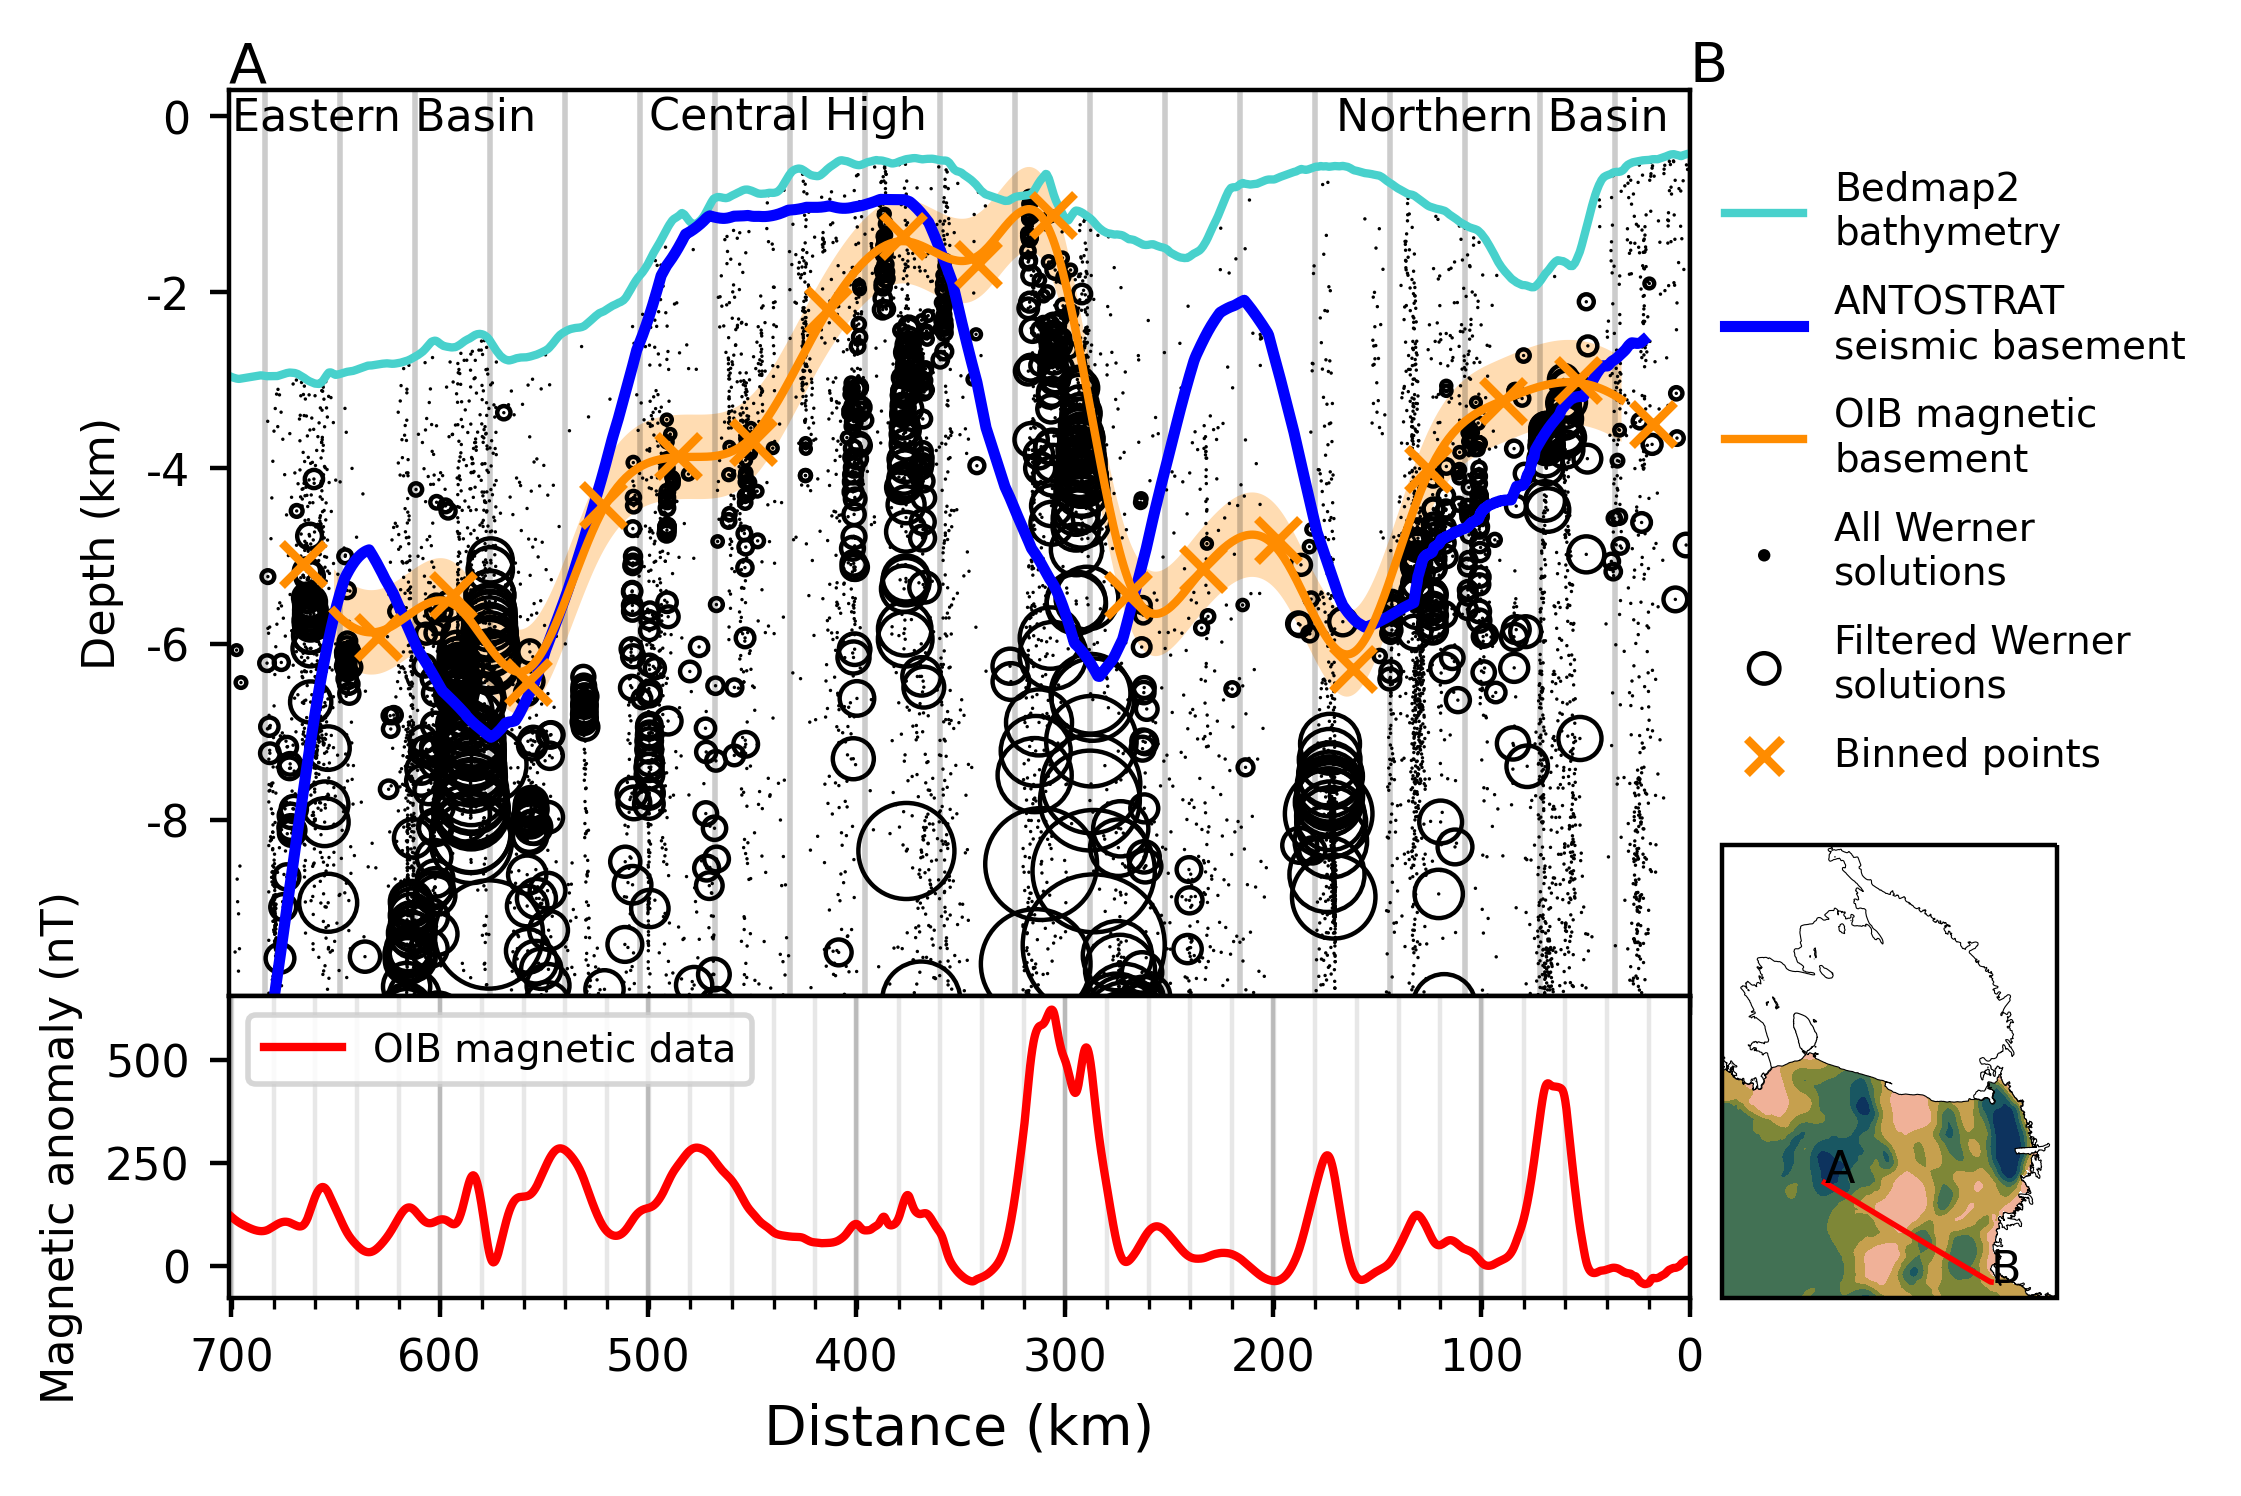

In [4]:
# initialize the figure
fig = plt.figure(dpi=400)
# set up 8x12 grid
gs = fig.add_gridspec(nrows=8, ncols=14)
# first axes uses rows 1-5, cols 1-12
ax0 = fig.add_subplot(gs[0:6,0:11])

#vertical lines of bin size
ax0.vlines(oib.Distance_36k.unique(),ymin=-10000, ymax=500, color='k', linewidth=1).set_alpha(.2)    

# bedmap2 bathymetry
ax0.plot(oib.Distance, oib.bedmap2_bed, 
         c='mediumturquoise', linewidth=1.5, label='Bedmap2\nbathymetry')

# ANTOSTRAT basement  
ax0.plot(oib.Distance,oib.ANTOSTRAT_basement,  
         c='blue', linewidth=2, label='ANTOSTRAT\nseismic basement')

# interpolated OIB basement
ax0.plot(oib_basement.Distance, oib_basement.filt_clip, 
         c='darkorange', 
         label='OIB magnetic\nbasement')

# uncertainty bounds
error=480
ax0.fill_between(oib_basement.Distance, 
                 oib_basement.filt_clip-error, 
                 oib_basement.filt_clip+error,
                 facecolor='darkorange', alpha=.3)
       
# OIB Werner dike solutions
ax0.scatter(oib.Distance, oib.Depth, 
            s = 1.5, marker='.', edgecolor='none', facecolor='k', 
            label='All Werner\nsolutions')

# OIB filtered solutions, scaled by Susc
ax0.scatter(oib.Distance[oib.Depth_36k.notna()], 
            oib.Depth_36k[oib.Depth_36k.notna()],
            s = oib[oib.Depth_36k.notna()].Susc*3, 
            marker='o', edgecolors='k', facecolors='none', 
            linewidth=.8, label='Filtered Werner\nsolutions')

# binned OIB basement solutions
ax0.scatter(oib_basement.Distance[oib_basement.binned==1], 
            oib_basement.Depth_36k[oib_basement.binned==1],
            marker='x', c='darkorange', s=60, zorder=15, 
            label='Binned points')
"""

add subplot of magnetics data

"""   
# second axes uses rows 5-8 and cols 1-12
ax1 = fig.add_subplot(gs[6:8,0:11],
                      sharex=ax0)

ax1.plot(oib_mag.Distance, oib_mag.Mag_anom_draped_1000, 
            c='r', label='OIB magnetic data')
ax1.yaxis.tick_left()
ax1.yaxis.set_label_position("left")  
ax1.legend(fontsize=7, markerscale=6) 

"""

Set figure ticks, limits, and parameters

"""    
ax1.set_xlim(oib.Distance.max(), oib.Distance.min()) 
ax1.set_xticks(np.arange(oib.Distance.min(), oib.Distance.max(), 100000))
ax1.set_xticklabels(np.arange(0, int((oib.Distance.max())/1000), 100))
ax1.set_xticks(np.arange(0, int((oib.Distance.max())), 20000), minor=True)
ax1.tick_params(axis='both', labelsize=8)
ax0.tick_params(axis='both', labelsize=8)

ax0.set_ylim(-10000, 300)
ax0.set_yticks((-8000, -6000, -4000, -2000, 0))
ax0.set_yticklabels((-8, -6, -4, -2, 0))

ax1.set_axisbelow(True)
ax1.grid(axis='x', which='major', alpha=0.8)
ax1.grid(axis='x', which='minor', alpha=0.3)
ax0.set_ylabel('Depth (km)', size=8)
ax1.set_ylabel('Magnetic anomaly (nT)', size=8)
ax1.set_xlabel('Distance (km)')

ax0.text(x=oib.Distance.max(), y=400, s='A', fontsize=10)
ax0.text(x=oib.Distance.min(), y=400, s='B', fontsize=10)

ax0.tick_params(axis='x', which='both', labelbottom=False) # remove tick labels

"""

make inset location plot

"""
# load groundingline
file='../data/shapefiles/GroundingLine_Antarctica_v02.shp'
land=ShapelyFeature(Reader(file).geometries(),
                    ccrs.SouthPolarStereo(), edgecolor='black')
# load coastline
file='../data/shapefiles/Coastline_Antarctica_v02.shp'
shelves=ShapelyFeature(Reader(file).geometries(),
                    ccrs.SouthPolarStereo(), edgecolor='black')
# load ANTOSTRAT basement 
file='../data/results/Lindeque_bedmachine_basement.nc'
nc = Dataset(file)
x=nc.variables['x'][:]
y=nc.variables['y'][:]
z=nc.variables['z'][:]

ax2 = fig.add_subplot(gs[5:8,11:14],
                      projection=ccrs.SouthPolarStereo())
ax2.set_extent([165, 198, -86, -71], crs=ccrs.PlateCarree())

# plot ANTOSTRAT basement
ax2.contourf(x,y,z,transform = ccrs.SouthPolarStereo(), cmap=cm.batlowW)

# plot ice shelf and coastline
ax2.add_feature(shelves, facecolor='white',#'lightcyan', 
                linewidth=0.2)

# plot land and groundingline
ax2.add_feature(land, facecolor='white',#'navajowhite', 
                linewidth=.2)

# plot OIB line on map
ax2.plot(oib_mag.x, oib_mag.y, c='r', linewidth=1,
            transform = ccrs.SouthPolarStereo())

# plot start and stop of OIB line
ax2.text(x=oib_mag.x.iloc[0], y=oib_mag.y.iloc[0], s='B', fontsize=8,
            transform = ccrs.SouthPolarStereo())
ax2.text(x=oib_mag.x.iloc[-1], y=oib_mag.y.iloc[-1], s='A', fontsize=8,
            transform = ccrs.SouthPolarStereo())

# add locations
ax0.text(x=700000, y=-150, s='Eastern Basin', fontsize=8)
ax0.text(x=500000, y=-150, s='Central High', fontsize=8)
# ax0.text(x=340000, y=-150, s='Central Basin', fontsize=8)
ax0.text(x=170000, y=-150, s='Northern Basin', fontsize=8)

# add legend to right side
lgnd = ax0.legend(bbox_to_anchor=(1,.95), frameon=False, bbox_transform=ax0.transAxes, fontsize=7, labelspacing=.8)
lgnd.legendHandles[-3]._sizes = [20]
lgnd.legendHandles[-2]._sizes = [30]
lgnd.legendHandles[-1]._sizes = [40]

fig.subplots_adjust(hspace=0, wspace=0)

# fig.show()

## Save figure

In [12]:
out='outputs/FigS2_OIB_403_3.jpg'
fig.savefig(out, dpi=400)